In [207]:
import shap
from shap._explanation import Cohorts
import pickle
import numpy as np
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order, plot_2d, \
                       plot_feature_importance_bar, plot_feature_importance_scatter, plot_feature_effects, plot_forces, \
                       ensure_shap_values_are_3d
from util import get_rules
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
shap.initjs()
%matplotlib inline
task_name = '01'

In [3]:
with open(task_name + '.models', 'rb') as f:
    comparer = pickle.load(f)
with open(task_name + '.expl', 'rb') as f:
    #explanations, _, _ = pickle.load(f)
    explanations = pickle.load(f)

# Local Explanations

Here we will use the explanations obtained globally for the multiclass difference classifier to cluster instances, and inspect the individual classifiers explanations on a local level for selected clusters.

In [4]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
explanations_diff = explanations[is_pred_diff]

## Supervised Clustering of Instances by their Explanations

We fit a regression tree on the original features to predict the difference class SHAP values of the multiclass difference classifier. Instances are weighted by their probability of the classifiers predicting differently, in order for it to focus on the interesting regions.

In [174]:
n_clusters = 20
cluster_names = np.array([f'c{i+1}' for i in range(n_clusters)])
shap_values = explanations.mclass_diff.labels[:, :, comparer.difference_class_names]
shap_values = ensure_shap_values_are_3d(shap_values)
values = shap_values.values.reshape(
        (shap_values.values.shape[0],
         shap_values.values.shape[1] * shap_values.values.shape[2]))
tree = DecisionTreeRegressor(max_leaf_nodes=n_clusters)
diff_proba = comparer.predict_bin_diff_proba(shap_values.data)
tree.fit(shap_values.data, values, sample_weight=diff_proba)

DecisionTreeRegressor(max_leaf_nodes=20)

Now, let's see what the tree looks like. For each leaf, the cluster number is included and the number of instances in each class of the multiclass difference classifier.

In [175]:
leaf_node_ids = np.where(tree.tree_.children_left == -1)[0]
def predict_clusters(X):
    node_ids = tree.apply(X)
    return np.searchsorted(leaf_node_ids, node_ids)
cluster_numbers  = predict_clusters(explanations.data)

In [176]:
occurences = np.zeros((leaf_node_ids.shape[0], comparer.classes.shape[0]), dtype=int)
mclass_diff = comparer.predict_mclass_diff(explanations.data)
for class_idx in comparer.classes:
    indices, counts = np.unique(cluster_numbers[mclass_diff == class_idx], return_counts=True)
    occurences[indices, class_idx] = counts
occurences = pd.DataFrame(occurences, index=leaf_node_ids, columns=comparer.class_names)

Now that we have obtained a global clustering, we extract all relevant clusters with a share of at least 10% of instances with different predictions. This threshould in combination with 20 clusters gave the best clustering results.

In [177]:
threshold_pct = 0.10
diff_occurences = occurences.iloc[:, comparer.difference_classes].sum(axis=1)
total_occurences = occurences.sum(axis=1)
diff_share = diff_occurences / total_occurences
clusters_diff_indices = np.where(diff_share > threshold_pct)[0]

In [178]:
mask = np.apply_along_axis(lambda a: np.isin(a, clusters_diff_indices), 0, cluster_numbers)
explanations_sliced = explanations[is_pred_diff & mask]
diff_cluster_numbers = predict_clusters(explanations_sliced.data)
explanations_clustered = explanations_sliced.cohorts(cluster_names[diff_cluster_numbers])

Now we get that many clusters of interest:

In [179]:
clusters_diff_indices.shape[0]

6

What is the share of instances with different outcomes that are included in these clusters?

In [180]:
np.sum(comparer.predict_bin_diff(explanations_sliced.data)) / np.sum(is_pred_diff)

0.6607669616519174

What are the shares within these clusters of instances with different predictions?

In [181]:
diff_share.iloc[clusters_diff_indices]

14    0.302013
20    0.666667
24    0.234043
27    0.285714
31    0.294872
34    0.106250
dtype: float64

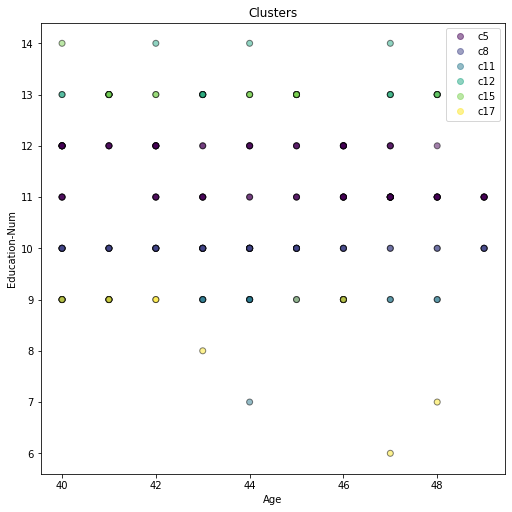

In [182]:
idx_x, idx_y = 0, 2
mapping = dict([(cluster_number, idx) for idx, cluster_number in enumerate(clusters_diff_indices, 1)])
reduced_cluster_numbers = [mapping[no] if no in mapping.keys() else 0 for no in diff_cluster_numbers]
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
scatter = ax.scatter(explanations_sliced.display_data[:, idx_x],
                     explanations_sliced.display_data[:, idx_y],
                     c=reduced_cluster_numbers, alpha=0.5, edgecolors='k')
ax.set_xlabel(comparer.feature_names[idx_x])
ax.set_ylabel(comparer.feature_names[idx_y])
ax.set_title('Clusters')
ax.legend(scatter.legend_elements()[0], cluster_names[clusters_diff_indices].tolist());

We already see, that Education-Num values 15 and 16 are not included in this clustering.

Since the decision tree is too big to be visualized, we only extract decision rules for the leafs of interest and see, that the age group between 39.5 and 49.5 is affected.

In [206]:
rules = get_rules(tree, comparer.feature_names)
diff_cluster_rules = np.array(rules)[clusters_diff_indices]
print('\n'.join([f'{cluster_name}: {rule}' for cluster_name, rule in zip(cluster_names[clusters_diff_indices], diff_cluster_rules)]))

c5: (Age > 39.5) & (Age <= 49.5) & (Hours per week <= 53.5) & (Education-Num > 10.5) & (Education-Num > 12.5) & (Relationship <= 1.5) [652 samples]
c8: (Age > 39.5) & (Age <= 49.5) & (Hours per week <= 53.5) & (Education-Num > 10.5) & (Education-Num <= 12.5) & (Relationship > 3.5) [298 samples]
c11: (Age > 39.5) & (Age <= 49.5) & (Hours per week > 53.5) & (Education-Num <= 10.5) & (Education-Num <= 9.5) & (Hours per week <= 64.0) [184 samples]
c12: (Age > 39.5) & (Age <= 49.5) & (Hours per week <= 53.5) & (Education-Num <= 10.5) & (Capital Loss > 1446.5) [160 samples]
c15: (Age > 39.5) & (Age <= 49.5) & (Hours per week <= 53.5) & (Education-Num > 10.5) & (Education-Num > 12.5) & (Relationship > 1.5) & (Capital Gain <= 57511.5) & (Hours per week > 31.0) & (Race <= 1.5) [78 samples]
c17: (Age > 39.5) & (Age <= 49.5) & (Hours per week <= 53.5) & (Education-Num > 10.5) & (Education-Num > 12.5) & (Relationship > 1.5) & (Capital Gain <= 57511.5) & (Hours per week <= 31.0) [56 samples]


### Feature Influence

Obtain a feature order, ranked by mean absolute influence on the instances with different predictions:

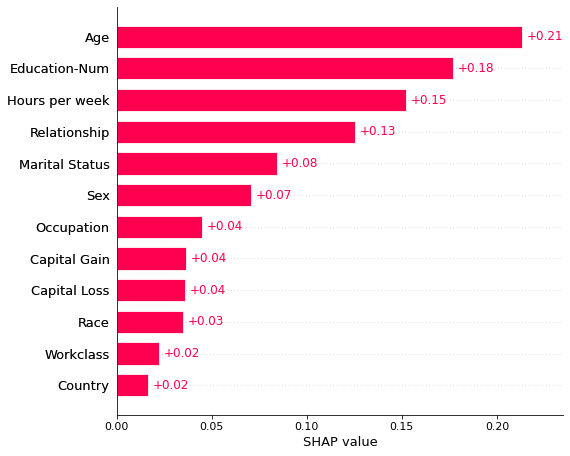

In [209]:
feature_order, feature_importance = calc_feature_order(explanations.bin_diff.labels[is_pred_diff])
plot_feature_importance_bar(feature_importance)

When comparing the mean influence per feature of each cluster, we notice that the influence of x1, which does have a lower influence overall on the predictions being different, has influence on what difference class is most present in a cluster (negative influences).

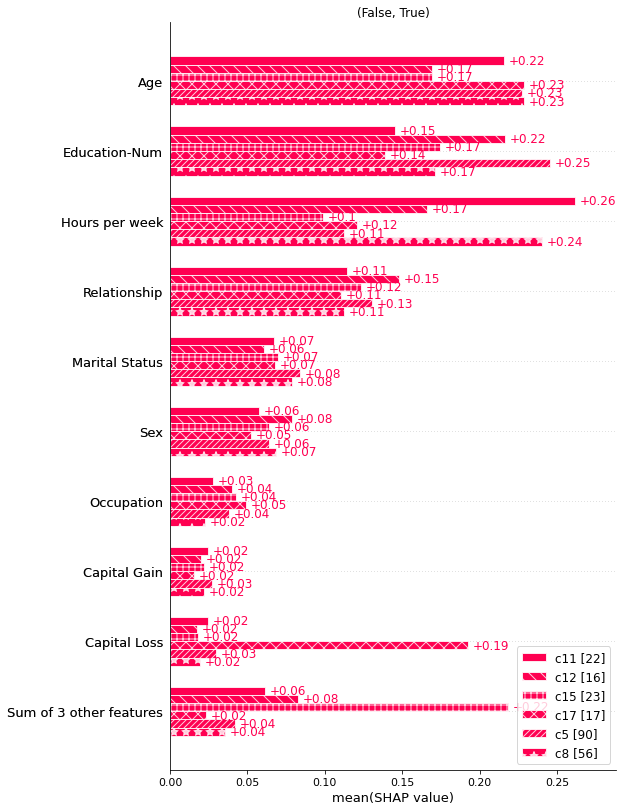

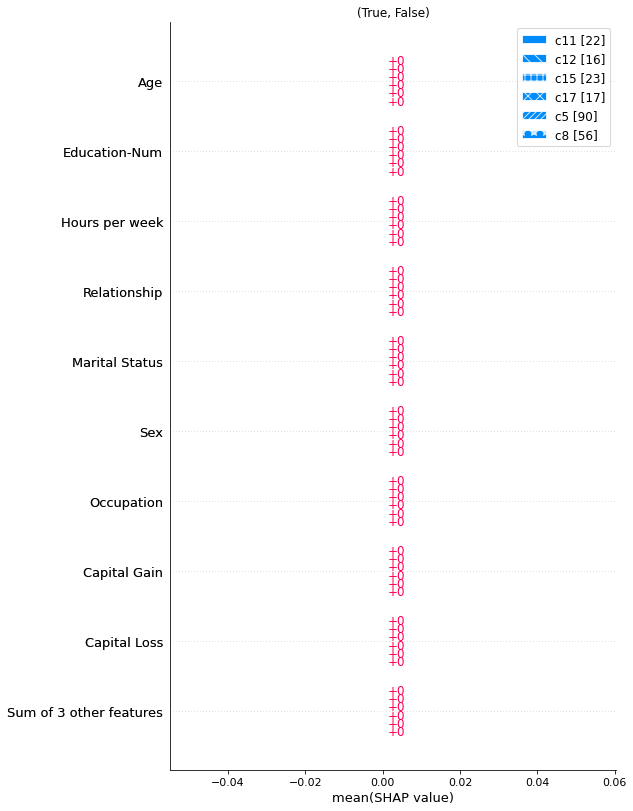

In [213]:
for label in comparer.difference_class_names:
    plt.title(label)
    shap.plots.bar(explanations_clustered.mclass_diff.labels[:, :, label].mean(0), order=feature_order)

### Feature Effects

This can be skipped, since the global plots had all the information already.

### Decision Plot

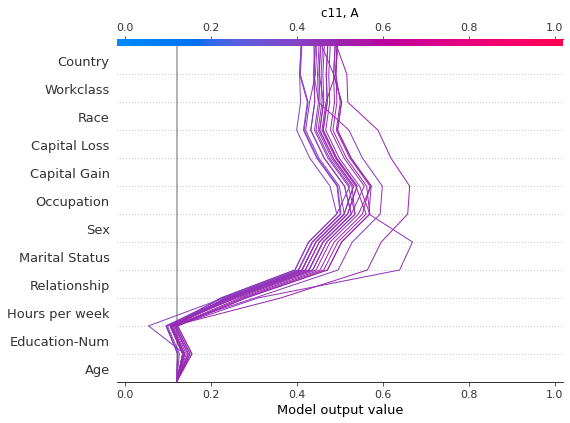

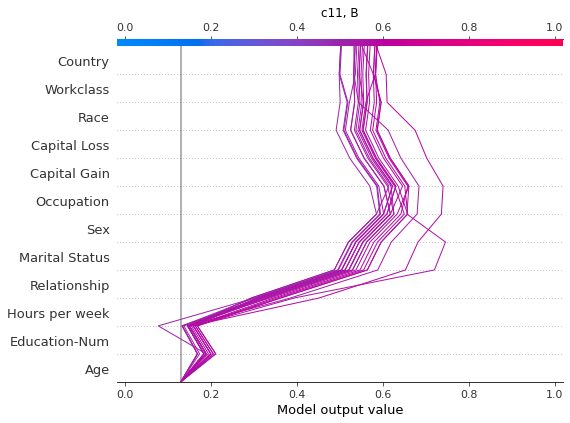

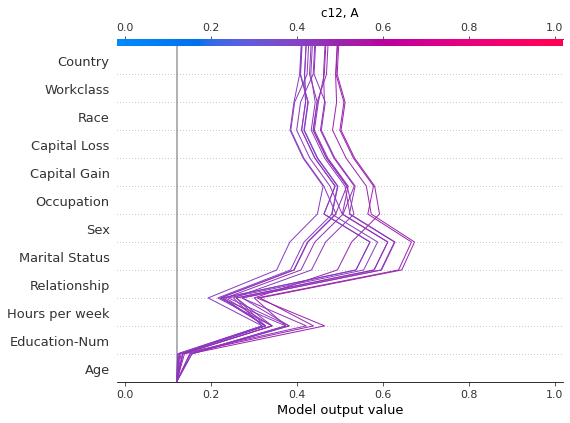

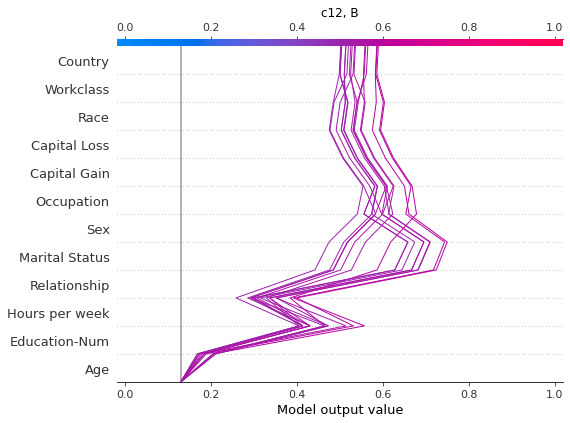

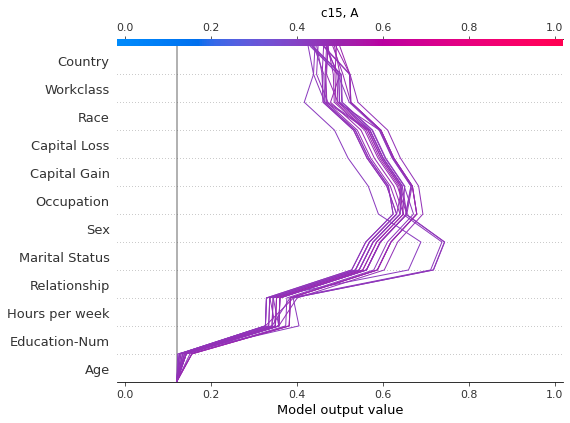

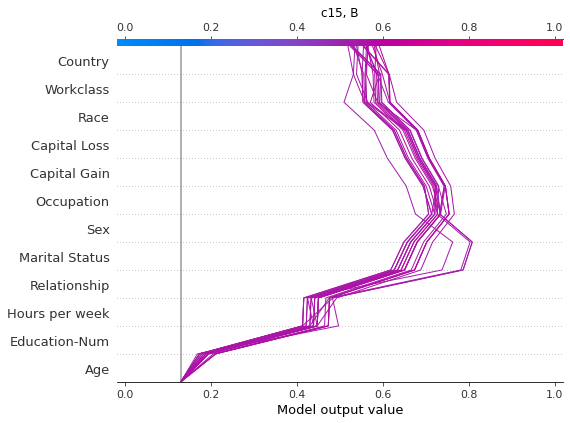

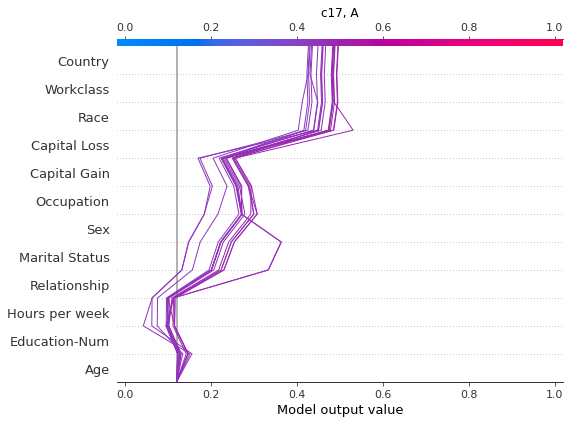

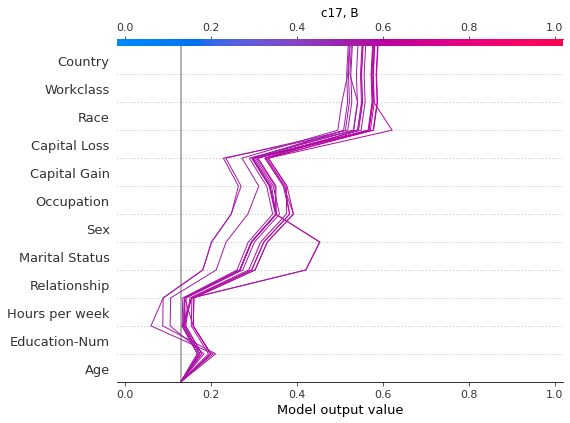

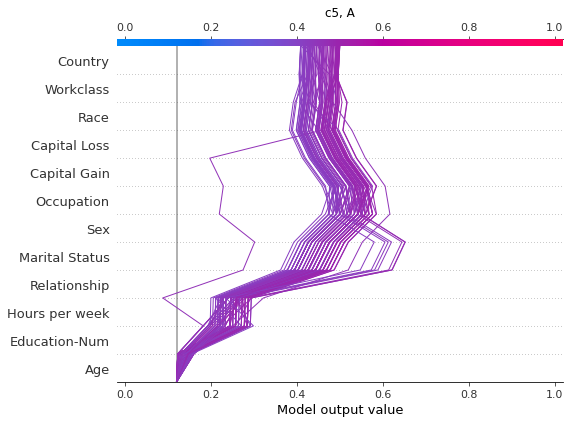

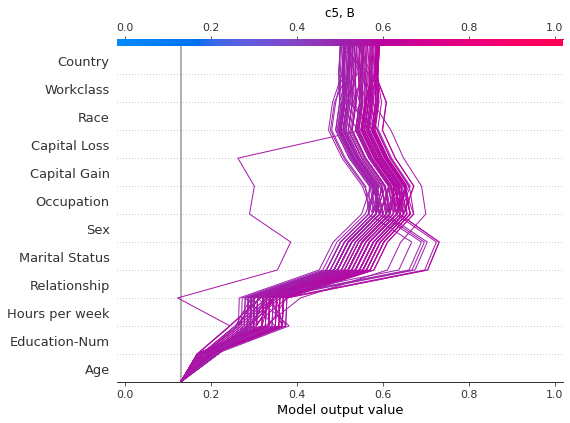

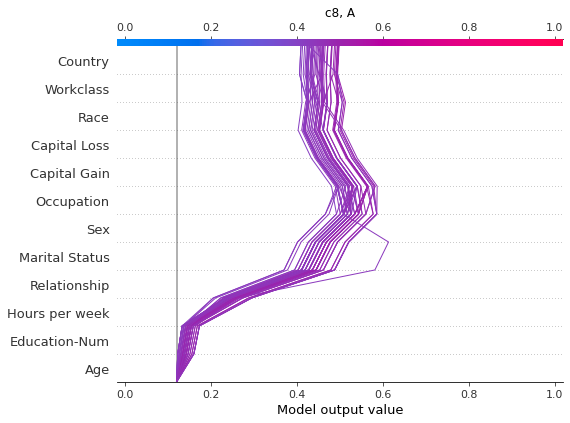

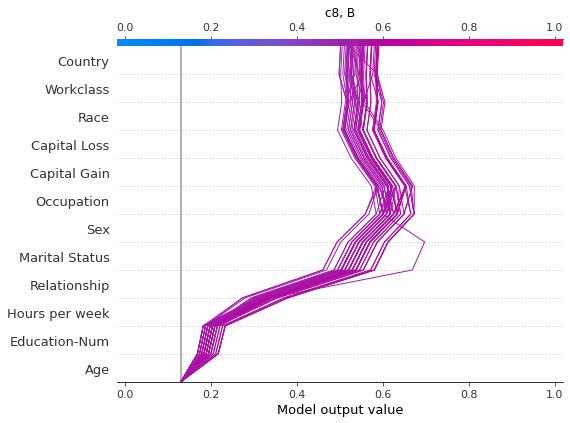

In [217]:
indiv = explanations_clustered.indiv.log_odds[:, :, 1]
for cluster_name in indiv.A.cohorts.keys():
    for clf_name, shap_values in [('A', indiv.A), ('B', indiv.B)]:
        shap_values = shap_values.cohorts[cluster_name]
        shap.decision_plot(shap_values.base_values[0], shap_values.values, features=shap_values.data,
                           feature_names=shap_values.feature_names, feature_order=feature_order,
                           link='logit', title=f'{cluster_name}, {clf_name}')

### Force Plot

Furthermore we visualize the instances in force plots, ordered by similarity of their multiclass difference classes.

In [218]:
indiv = explanations_clustered.indiv.log_odds[:, :, 1]
for cluster_name in indiv.A.cohorts.keys():
    instance_order = calc_instance_order(
        explanations_clustered.mclass_diff.log_odds[
            :,
            :,
            comparer.difference_class_names
        ].cohorts[cluster_name])
    for clf_name, shap_values in [('A', indiv.A), ('B', indiv.B)]:
        shap_values = shap_values.cohorts[cluster_name]
        plot = shap.plots.force(
            base_value=shap_values.base_values[0],
            shap_values=shap_values.values,
            features=shap_values.data,
            feature_names=shap_values.feature_names,
            out_names=f'{cluster_name}, {clf_name}',
            ordering_keys=instance_order.tolist(),
            link='logit')
        display(plot)